In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
import cvxpy as cvx

In [2]:
picString = ""
with open("wonderland-tree.txt") as file:
    for line in file:
        picString += line.strip()
picArray = np.array([int(s) for s in picString])
picArray.reshape((1200, 1))
print picArray.shape

(1200L,)


In [3]:
k = np.sum(picArray)
n = len(picArray)
print "K:", k
print "N:", n
print "k/n:", float(k)/n

K: 252
N: 1200
k/n: 0.21


In [4]:
A = np.random.randn(1200*1200).reshape((1200, 1200))
print A.shape

(1200L, 1200L)


In [5]:
A600 = A[:600, :]
print A600.shape

(600L, 1200L)


In [54]:
from PIL import Image
img = np.array(Image.open("wonderland-tree.png"), dtype=float)[:, :, 0]
print img.shape

(490L, 368L)


In [6]:
pic600 = np.dot(A600, picArray)
print pic600.shape

(600L,)


In [8]:
x = cvx.Variable(1200)
constraints = [A600 * x == pic600, x >= 0]
objective = cvx.Minimize(sum(cvx.abs(x - picArray)))
prob = cvx.Problem(objective, constraints)
prob.solve()

-1.762771674314472e-13

In [17]:
r = 600
Ar = A[:r, :]
picR = np.dot(Ar, picArray)
x = cvx.Variable(1200)
constraints = [Ar * x == picR, x >= 0]
objective = cvx.Minimize(sum(cvx.abs(x - picArray)))
prob = cvx.Problem(objective, constraints)
prob.solve()

-1.762771674314472e-13

In [2]:
from PIL import Image

Recover a corrupted image using linear programming package in Python, cvxpy.

In [4]:
corrupt = np.array(Image.open("corrupted.png"), dtype=int)[:, :, 0]
known = (corrupt > 0).astype(int)
print "Ratio of pixels known:", np.mean(known)

Ratio of pixels known: 0.700816424954


Image has been corrupted by overlaid text and roughly 30% of pixels are missing.

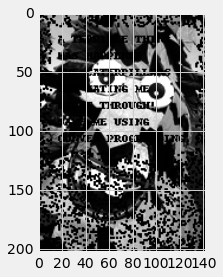

In [7]:
plt.gray();
plt.imshow(corrupt);

Display the correct image.

In [8]:
correct = np.array(Image.open("stanford-tree.png"), dtype=int)[:, :, 0]
known = (correct > 0).astype(int)
print "Ratio of pixels known:", np.mean(known)

Ratio of pixels known: 1.0


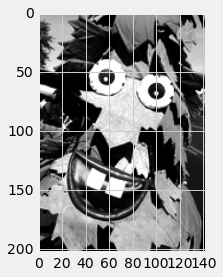

In [9]:
plt.imshow(correct);

The image file is 203 by 143 pixels in size.

In [15]:
rowmax, colmax = corrupt.shape[0], corrupt.shape[1]
print rowmax, colmax

203 143


In [12]:
from copy import deepcopy

This method attempts to fill in the missing pixels by filling in the missing values with the average value of neighboring pixels that are non-zero in value. If there are no known neighbors, the pixel value of 0 is kept.  This lead to roughly 96.5% of the pixels being non-zero but the image recovered is not particularly close to the correct image.

In [18]:
fillFix = deepcopy(corrupt)
for row in range(rowmax):
    for col in range(colmax):
        if corrupt[row, col] == 0:
            rowlow = row - 1
            rowhigh = row + 1
            collow = col - 1
            colhigh = col + 1
            neighborVals= []
            for r in range(rowlow, rowhigh + 1, 1):
                for c in range(collow, colhigh + 1, 1):
                    if r >=0 and c >= 0 and r < rowmax and c < colmax:
                        neighborVals.append(corrupt[r, c])
            fillFix[row, col] = np.mean(neighborVals)

In [19]:
fillKnown = (fillFix > 0).astype(int)
print "Ratio known after filling:", np.mean(fillKnown)

Ratio known after filling: 0.96562058631


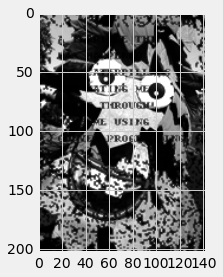

In [20]:
plt.imshow(fillFix);

Known is a matrix of 0s and 1s where a value of 1 indicates that the corrupt image's pixel value at that location is the same as the pixel value of the correct image.

In [28]:
Known = np.zeros((rowmax, colmax))
for i in xrange(rowmax):
    for j in xrange(colmax):
        if corrupt[i, j] == correct[i, j]:
            Known[i, j] = 1
print np.mean(Known)

0.700816424954


In [31]:
U = cvx.Variable(*corrupt.shape)
obj = cvx.Minimize(cvx.tv(U))
constraints = [cvx.mul_elemwise(Known, U) == cvx.mul_elemwise(Known, corrupt)]
prob = cvx.Problem(obj, constraints)
prob.solve(verbose = True, solver = cvx.SCS)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 163764, CG tol ~ 1/iter^(2.00)
eps = 1.00e-003, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 57713, constraints m = 115081
Cones:	primal zero / dual free vars: 29029
	soc vars: 86052, soc blks: 28684
Setup time: 1.73e-002s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|3.01e+000 3.39e+000 1.00e+000 -8.01e+006 1.84e+006 1.85e-009 1.62e-001 
   100|1.24e-003 7.03e-004 3.02e-004 7.51e+005 7.52e+005 5.78e-010 3.29e+000 
   120|8.24e-004 4.49e-004 1.69e-004 7.52e+005 7.52e+005 5.79e-010 3.86e+000

751587.7465348362

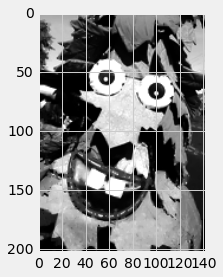

In [32]:
plt.imshow(U.value);

Calculate the Frobenius norm of the differences between correct and corrupted image and the correct image and the 2 methods of recovery.  The image reconstruction method using linear programming performs much better than the method of looking at averaging neighboring pixels.

In [37]:
diffCorrupt = correct - corrupt
diffFill = correct - fillFix
diffRec = correct - U.value
print "Frobenius norm of difference between correct and corrupt:", np.linalg.norm(diffCorrupt)
print "Frobenius norm of difference between correct and simple fill:",np.linalg.norm(diffFill)
print "Frobenius norm of difference between correct and reconstruction:", np.linalg.norm(diffRec)

Frobenius norm of difference between correct and corrupt: 12725.3959467
Frobenius norm of difference between correct and simple fill: 8525.96663141
Frobenius norm of difference between correct and reconstruction: 2950.77240357
